In [4]:
using LinearAlgebra
using Plots
using SparseArrays

In [256]:
function calc_Lagrange_coeff(N_Lagrange, μ)
    @assert N_Lagrange===5 || N_Lagrange===7 || N_Lagrange===9
    if N_Lagrange == 5
        if abs(μ) == 1
            return 2/3*sign(μ)
        end
        if abs(μ) == 2
            return -1/12*sign(μ)
        end
    end
    
    if N_Lagrange == 7
        if abs(μ) == 1
            return 3/4*sign(μ)
        end
        if abs(μ) == 2
            return -3/20*sign(μ)
        end
        if abs(μ) == 3
            return 1/60*sign(μ)
        end
    end
    
    if N_Lagrange == 9
        if abs(μ) == 1
            return 4/5*sign(μ)
        end
        if abs(μ) == 2
            return -1/5*sign(μ)
        end
        if abs(μ) == 3
            return 4/105*sign(μ)
        end
        if abs(μ) == 4
            return -1/280*sign(μ)
        end
    end
    return 0.0
end

calc_Lagrange_coeff (generic function with 2 methods)

In [258]:
N_Lagrange=9
@time calc_Lagrange_coeff(9, +1)
@show calc_Lagrange_coeff(N_Lagrange, +1) calc_Lagrange_coeff(N_Lagrange, -1)
@show calc_Lagrange_coeff(N_Lagrange, +2) calc_Lagrange_coeff(N_Lagrange, -2)
@show calc_Lagrange_coeff(N_Lagrange, +3) calc_Lagrange_coeff(N_Lagrange, -3)
@show calc_Lagrange_coeff(N_Lagrange, +4) calc_Lagrange_coeff(N_Lagrange, -4)
@show calc_Lagrange_coeff(N_Lagrange, +5) calc_Lagrange_coeff(N_Lagrange, -5)

  0.000001 seconds
calc_Lagrange_coeff(N_Lagrange, 1) = 0.8
calc_Lagrange_coeff(N_Lagrange, -1) = -0.8
calc_Lagrange_coeff(N_Lagrange, 2) = -0.2
calc_Lagrange_coeff(N_Lagrange, -2) = 0.2
calc_Lagrange_coeff(N_Lagrange, 3) = 0.0380952380952381
calc_Lagrange_coeff(N_Lagrange, -3) = -0.0380952380952381
calc_Lagrange_coeff(N_Lagrange, 4) = -0.0035714285714285713
calc_Lagrange_coeff(N_Lagrange, -4) = 0.0035714285714285713
calc_Lagrange_coeff(N_Lagrange, 5) = 0.0
calc_Lagrange_coeff(N_Lagrange, -5) = 0.0


0.0

In [121]:
function calc_Lz_component(N_Lagrange, ix, iy, jx, jy)
    L = 0.0
    
    if ix === jx
        L += -im*(ix-0.5)*calc_Lagrange_coeff(N_Lagrange, jy-iy)
    end
    
    if iy === jy
        L +=  im*(iy-0.5)*calc_Lagrange_coeff(N_Lagrange, jx-ix)
    end
    
    return L
end

calc_Lz_component (generic function with 2 methods)

In [202]:
function make_XAπ(Nx, Ny, N_Lagrange)
    @assert iseven(Nx)
    @assert iseven(Ny)
    
    XAπ = zeros(ComplexF64, Nx*Ny, Nx*Ny, 2)
    
    for jy in 1:Ny, jx in 1:Nx
        j = jx + Nx*(jy-1)
        
        for iy in 1:Ny, ix in 1:Nx
            i = ix + Nx*(iy-1)
            
            L₁ = calc_Lz_component(N_Lagrange, ix, iy,   jx,   jy)
            L₂ = calc_Lz_component(N_Lagrange, ix, iy, 1-jx,   jy)
            L₃ = calc_Lz_component(N_Lagrange, ix, iy, 1-jx, 1-jy)
            L₄ = calc_Lz_component(N_Lagrange, ix, iy,   jx, 1-jy)
            
            π = +1
            XAπ[i,j,1] = L₁ + π*L₂ + π*L₃ + L₄
            
            π = -1
            XAπ[i,j,2] = L₁ + π*L₂ + π*L₃ + L₄
        end
    end
    
    return XAπ
end

function calc_Lz_eigvecs(Nx, Ny, XAπ; ε=1e-10)
    vals   = zeros(Float64, Nx*Ny, 2)
    vecs_R = zeros(Float64, Nx*Ny, Nx*Ny, 2) # real part
    vecs_I = zeros(Float64, Nx*Ny, Nx*Ny, 2) # imaginary part
    
    # π = +1
    iπ = 1
    vals[:,1], vecs_R[:,:,1] = eigen(XAπ[:,:,1]'*XAπ[:,:,1])
    @views for k in 1:Nx*Ny
        if abs(vals[k,1]) < ε
            vals[k,1] = 0.0
        else
            vals[k,1] = sqrt(vals[k,1])
            vecs_I[:,k,1] = real(XAπ[:,:,1]*vecs_R[:,k,1]/(im*vals[k,1]))
        end
    end
    
    # π = -1
    iπ = 2
    vals[:,2], vecs_R[:,:,2] = eigen(XAπ[:,:,2]'*XAπ[:,:,2])
    @views for k in 1:Nx*Ny
        vals[k,2] = sqrt(vals[k,2])
        vecs_I[:,k,2] = real(XAπ[:,:,2]*vecs_R[:,k,2]/(im*vals[k,2]))
    end
    
    return vals, vecs_R, vecs_I
end

# plot k-th eigenvector of Lz
function plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)
    @assert iπ === 1 || iπ === 2
    
    fs = zeros(Float64, Nx, Ny)
    for iy in 1:Ny, ix in 1:Nx
        i = ix + Nx*(iy-1)
        fs[ix,iy] = vecs_R[i,k,iπ]
    end
    
    @show vals[k,iπ]
    
    heatmap(fs; aspect_ratio=1)
end

plot_Lz_eigvec (generic function with 3 methods)

In [239]:
Nx = 8
Ny = 8

@time XAπ = make_XAπ(Nx, Ny, 9)
@time vals, vecs_R, vecs_I = calc_Lz_eigvecs(Nx, Ny, XAπ)

vals

  0.000095 seconds (2 allocations: 128.062 KiB)
  0.008874 seconds (539 allocations: 1.419 MiB)


64×2 Matrix{Float64}:
  0.0       0.500329
  0.0       0.741893
  0.0       0.860512
  0.0       0.892321
  0.0       0.95295
  0.0       0.985659
  0.0       0.997051
  0.0       0.999661
  1.33912   0.999986
  1.41308   1.12536
  1.66295   1.40115
  1.85111   1.63048
  1.94817   1.68909
  ⋮        
  9.78419  10.3145
 10.6022   10.4821
 10.885    10.8371
 11.4162   10.9508
 11.7311   12.0953
 12.4297   12.3374
 13.0308   13.0291
 13.0978   13.0955
 14.1465   14.1138
 14.224    14.2524
 17.2356   17.2339
 17.2381   17.2398

In [240]:
Nx = 16
Ny = 16

@time XAπ = make_XAπ(Nx, Ny, 9)
@time vals, vecs_R, vecs_I = calc_Lz_eigvecs(Nx, Ny, XAπ)

vals

  0.001036 seconds (2 allocations: 2.000 MiB)
  0.082813 seconds (2.04 k allocations: 21.436 MiB, 10.04% gc time)


256×2 Matrix{Float64}:
  0.0      0.439868
  0.0      0.623594
  0.0      0.698151
  0.0      0.751112
  0.0      0.820931
  0.0      0.842557
  0.0      0.880876
  0.0      0.922473
  0.0      0.952915
  0.0      0.973691
  0.0      0.982755
  0.0      0.986743
  0.0      0.994049
  ⋮       
 30.1773  30.1771
 30.1775  30.1777
 31.4276  31.4266
 31.4289  31.43
 32.1626  32.1622
 32.1643  32.1647
 35.0948  35.0949
 35.0949  35.0949
 36.0066  36.0066
 36.0066  36.0066
 40.9009  40.9009
 40.9009  40.9009

vals[k, iπ] = 1.521835672369947


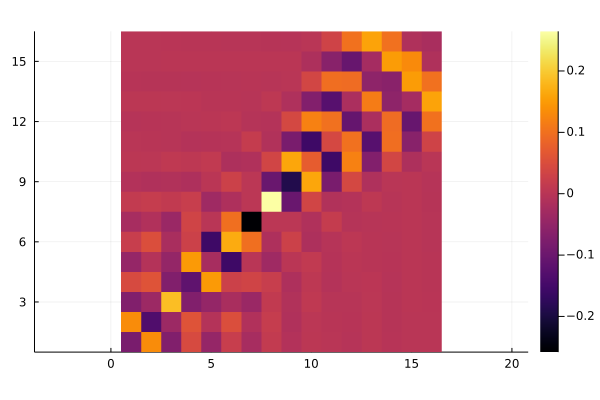

In [245]:
k = 20
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.5802329111238873


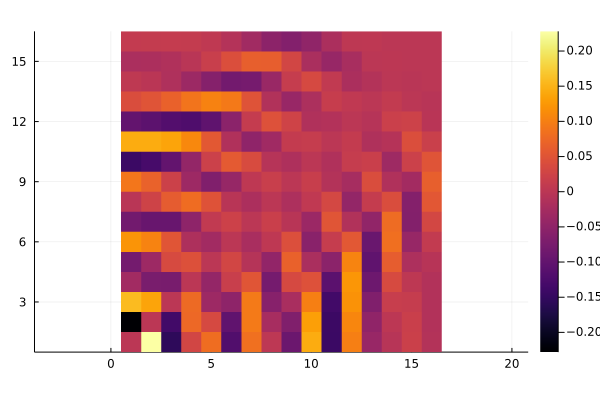

In [244]:
k = 21
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.7100006285808869


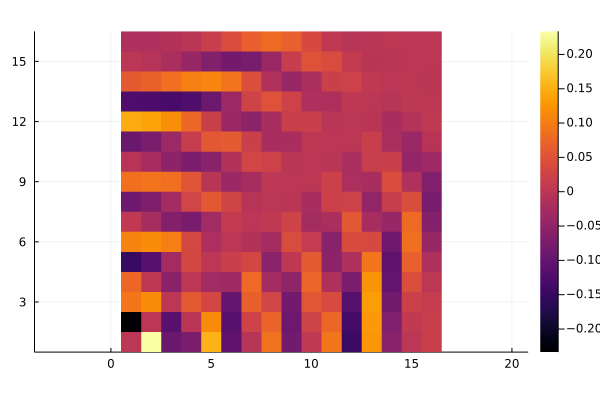

In [243]:
k = 22
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.8071422449006693


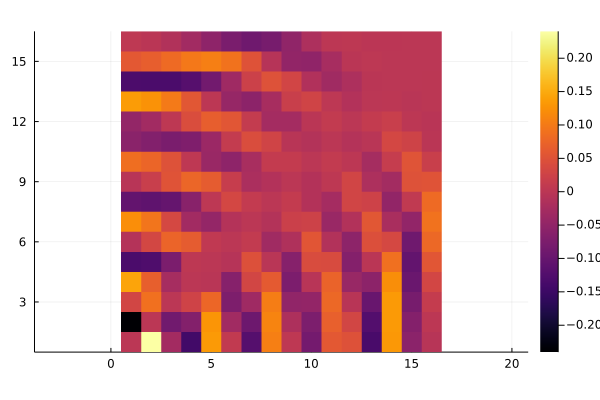

In [242]:
k = 23
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.8231627084634034


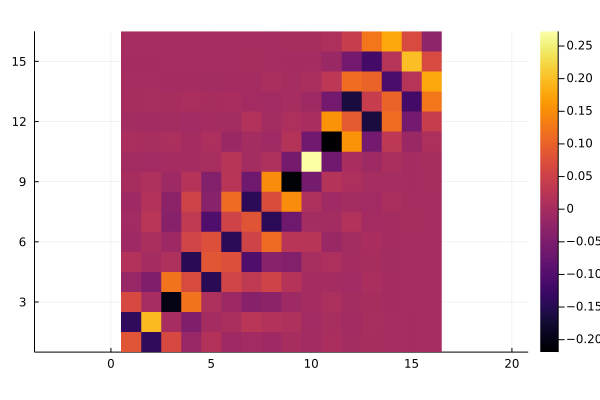

In [241]:
k = 24
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.8789157760527655


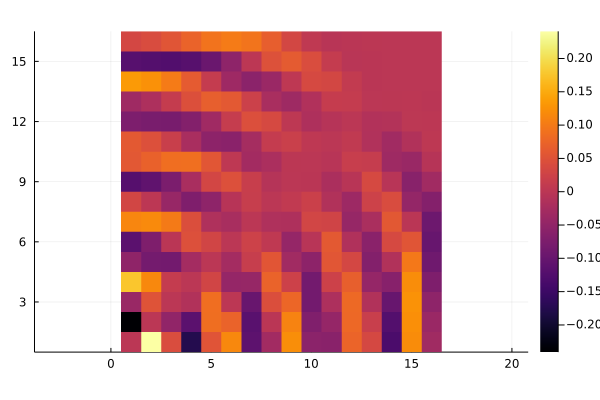

In [237]:
k = 25
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.929514376267059


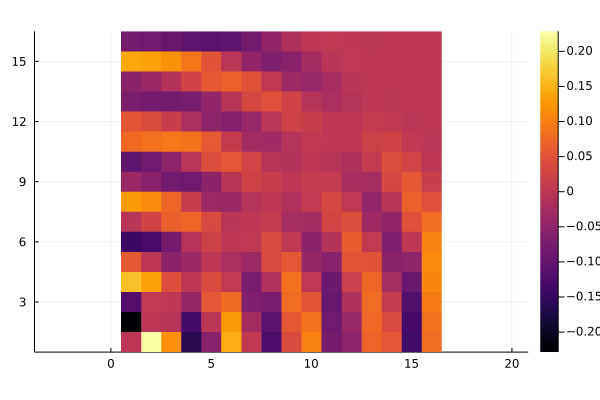

In [236]:
k = 26
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.9625890082259652


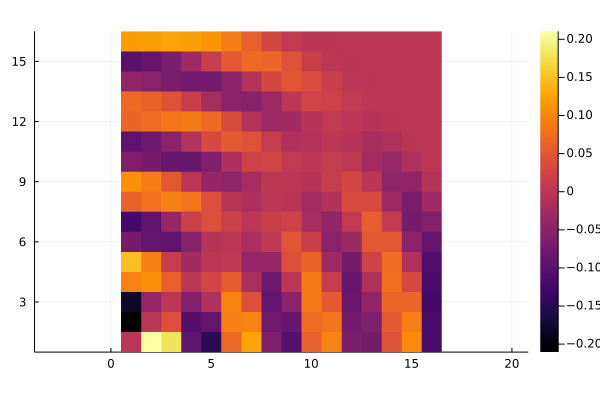

In [235]:
k = 27
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.9822166422235366


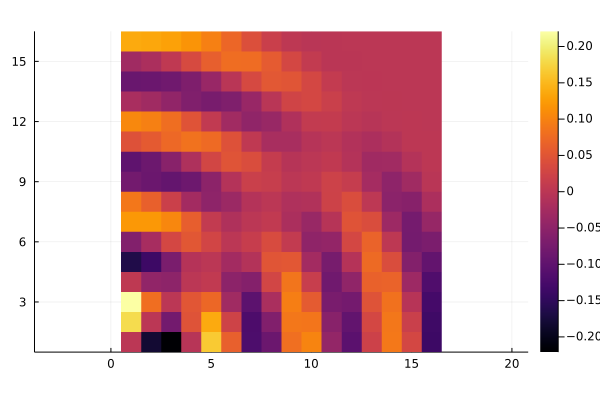

In [234]:
k = 28
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.9926000273087001


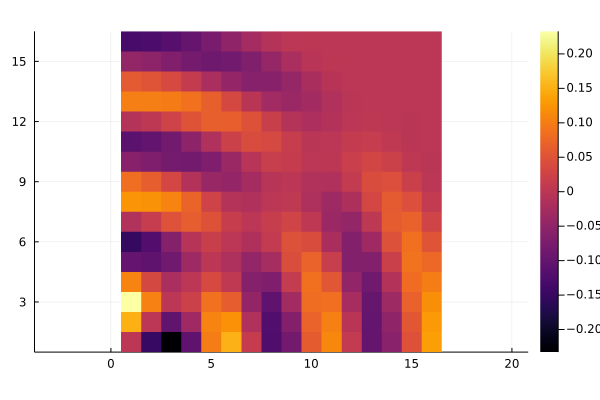

In [233]:
k = 29
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.9973912139433525


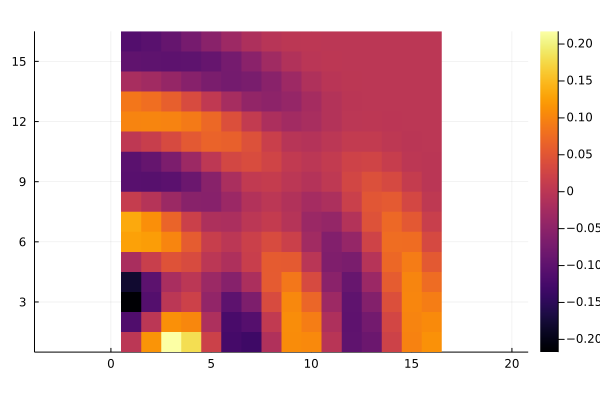

In [232]:
k = 30
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.9992592580153243


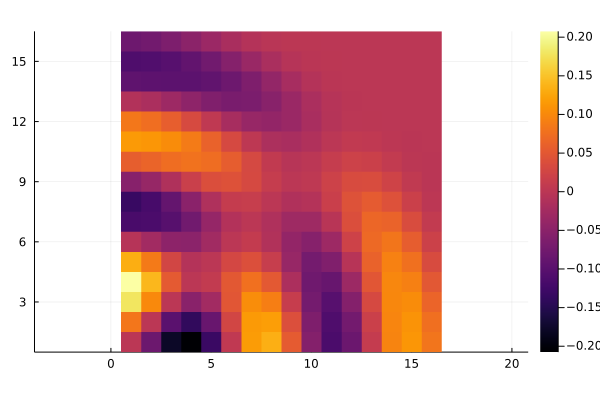

In [231]:
k = 31
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.9998443553112941


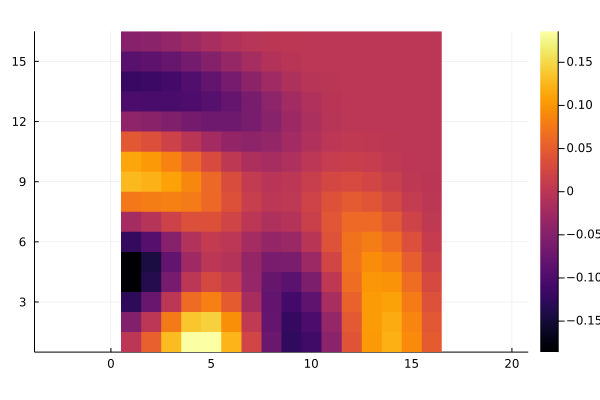

In [230]:
k = 32
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.999979374404616


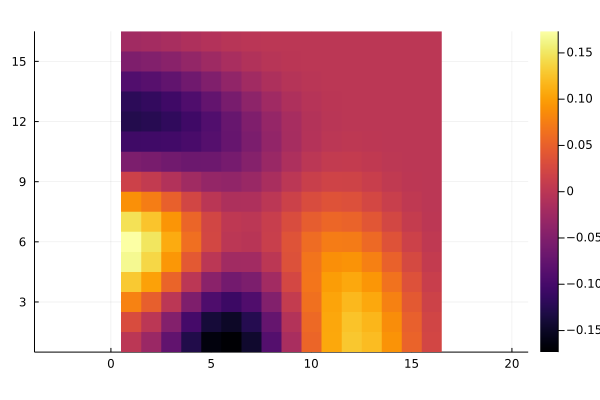

In [229]:
k = 33
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 1.9999988241640614


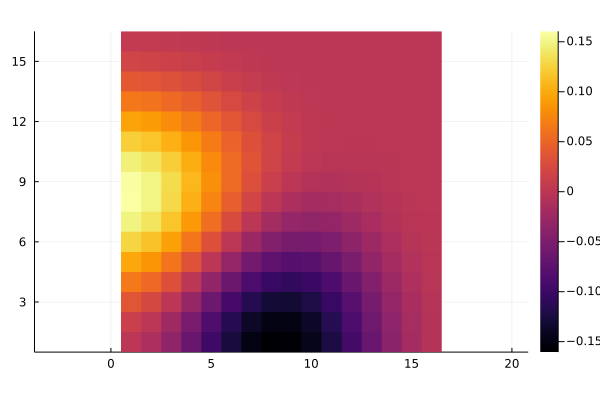

In [227]:
k = 34
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 2.104291998644121


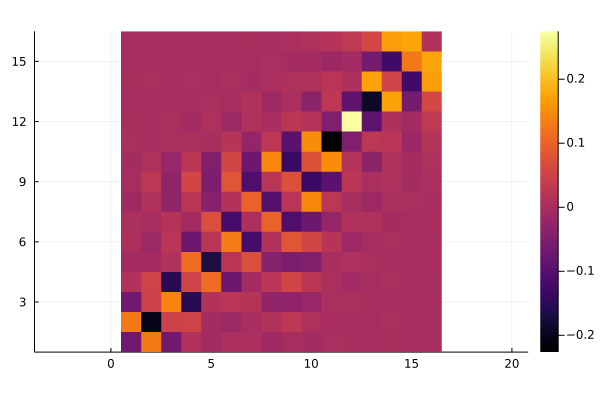

In [228]:
k = 35
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)

vals[k, iπ] = 2.356084978442531


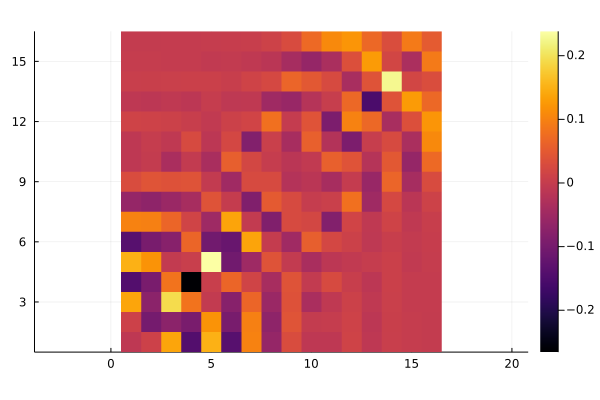

In [246]:
k = 36
iπ = 1
plot_Lz_eigvec(Nx, Ny, vals, vecs_R, k, iπ)